**The Game Sequence**

The player is numbered from 1, 2, ... the global variables *cards_on_board* and *the_cards* are what you get in the box when you buy Sequence. That is the board and cards. Also you will get discs in your player's colour.

This notebook contains the following functions:

  1. **initGame**(): returns the initial *discs_on_board* and deals out cards to the players stored in the list of lists called *hand*.
  2. **isTerminal**(discs_on_board, player): determines if the lookahead of *player* is terminal, if so this *player* wins
  3. **getMoves**(discs_on_board, hand, player) will return a list of tuples ($i,j$) for cards in hand, for normal cards (*legal_moves*) one eyed jacks (*legal_moves_1J*) and two eyed jacks (*legal_moves_2J*)
  4. **drawCard**(deck, hand, card_played) will return a new *hand[player-1]* for *player* and updated the deck by removing the top card. The *card_played* by the *player* is removed from its hand.
  5. **pretty_print**()

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

from SequenceGame import SequenceEnv

[[[-1  0  0  0  0  0  0  0  0 -1]
  [ 0  0  0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0  0  0]
  [-1  0  0  0  0  0  0  0  0 -1]]

 [[-1  0  0  0  0  0  0  0  0 -1]
  [ 0  0  0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0  0  0]
  [ 0  0  0  0  0  0  0  0  0  0]
  [-1  0  0  0  0  0  0  0  0 -1]]]
[[-1  0  0  0  0  0  0  0  0 -1]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [-1  0  0  0  0  0

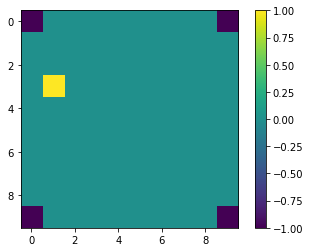

[[-1  0  0  0  0  0  0  0  0 -1]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [-1  0  0  0  0  0  0  0  0 -1]]


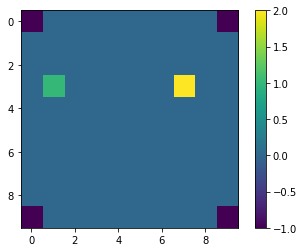

[[-1  0  0  0  0  0  0  0  0 -1]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [-1  0  0  0  0  0  0  0  0 -1]]


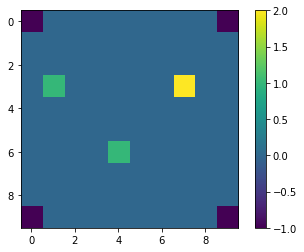

[[-1  0  0  0  0  0  0  0  0 -1]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [-1  0  0  0  0  0  0  0  0 -1]]


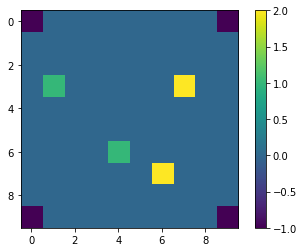

[[-1  0  0  0  0  0  0  0  0 -1]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0]
 [-1  0  0  0  0  0  0  0  0 -1]]


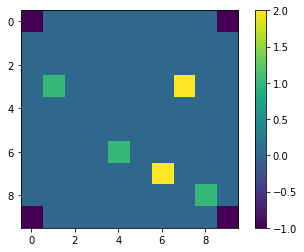

[[-1  0  0  0  0  0  0  2  0 -1]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  2  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0]
 [-1  0  0  0  0  0  0  0  0 -1]]


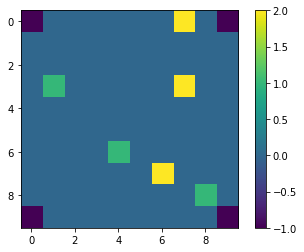

[[-1  0  0  0  0  0  0  2  0 -1]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  2  0  0]
 [ 0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0]
 [-1  0  0  0  0  0  0  0  0 -1]]


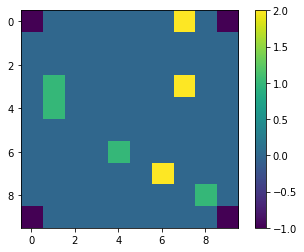

[[-1  0  0  0  0  0  0  2  0 -1]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  2  0  0]
 [ 0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  2]
 [ 0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0]
 [-1  0  0  0  0  0  0  0  0 -1]]


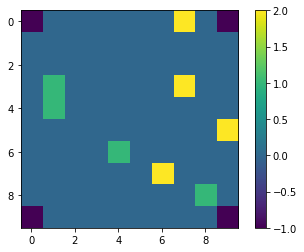

[[-1  0  0  0  0  0  0  2  0 -1]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  2  0  0]
 [ 0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  2]
 [ 0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0]
 [-1  0  0  0  0  0  0  1  0 -1]]


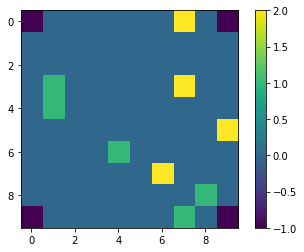

[[-1  0  0  0  0  0  0  2  0 -1]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  2  0  0]
 [ 0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  2]
 [ 0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  2  2  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0]
 [-1  0  0  0  0  0  0  1  0 -1]]


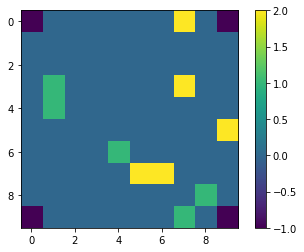

[[-1  0  0  0  0  0  0  2  0 -1]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  2  0  0]
 [ 0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  2]
 [ 1  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  2  2  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0]
 [-1  0  0  0  0  0  0  1  0 -1]]


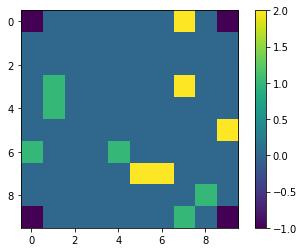

[[-1  0  0  0  0  0  0  2  0 -1]
 [ 0  0  0  0  0  2  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  2  0  0]
 [ 0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  2]
 [ 1  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  2  2  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0]
 [-1  0  0  0  0  0  0  1  0 -1]]


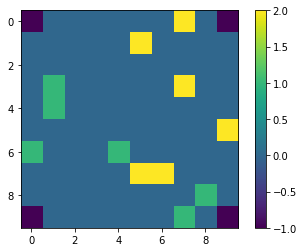

[[-1  0  0  0  0  0  0  2  0 -1]
 [ 0  0  0  0  0  2  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  0  0  2  0  0]
 [ 0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  2]
 [ 1  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  2  2  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0]
 [-1  0  0  0  0  0  0  1  0 -1]]


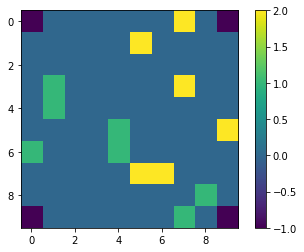

[[-1  0  0  0  0  0  0  2  0 -1]
 [ 0  0  0  0  0  2  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  2  0  0]
 [ 0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  2]
 [ 1  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  2  2  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0]
 [-1  0  0  0  0  0  0  1  0 -1]]


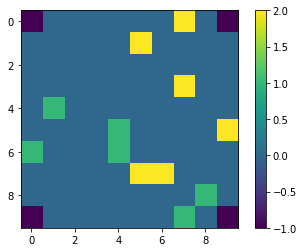

[[-1  0  0  0  0  0  0  2  0 -1]
 [ 0  0  0  0  0  2  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  2  0  0]
 [ 0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  2]
 [ 1  0  1  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  2  2  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0]
 [-1  0  0  0  0  0  0  1  0 -1]]


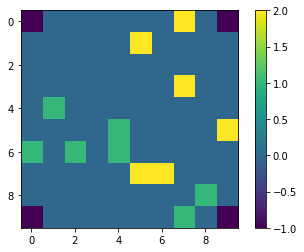

[[-1  0  0  0  0  0  0  2  0 -1]
 [ 0  0  2  0  0  2  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  2  0  0]
 [ 0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  2]
 [ 1  0  1  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  2  2  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0]
 [-1  0  0  0  0  0  0  1  0 -1]]


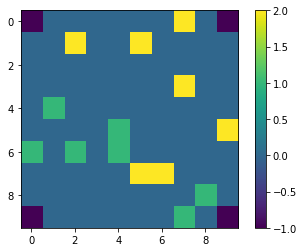

[[-1  0  0  0  0  0  0  2  0 -1]
 [ 0  0  2  0  0  2  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  2  0  0]
 [ 0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  2]
 [ 1  0  1  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  2  2  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0]
 [-1  0  0  0  0  0  0  1  0 -1]]


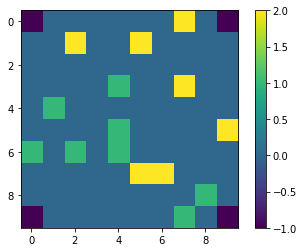

[[-1  0  0  0  0  0  0  2  0 -1]
 [ 0  0  2  0  0  2  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  2  0  0]
 [ 0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  2]
 [ 1  0  1  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  2  2  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0]
 [-1  0  0  0  0  0  0  1  0 -1]]


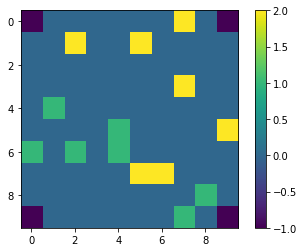

[[-1  0  0  0  0  0  0  2  0 -1]
 [ 0  0  2  0  0  2  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  2  0  0]
 [ 0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  0  2]
 [ 1  0  1  0  1  0  0  0  0  0]
 [ 1  0  0  0  0  2  2  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0]
 [-1  0  0  0  0  0  0  1  0 -1]]


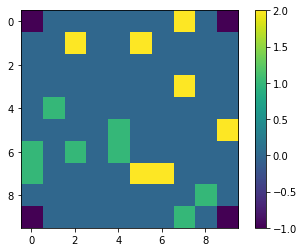

[[-1  0  0  0  0  0  0  2  0 -1]
 [ 0  0  2  0  0  2  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  2  0  0]
 [ 0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  2  0  2]
 [ 1  0  1  0  1  0  0  0  0  0]
 [ 1  0  0  0  0  2  2  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0]
 [-1  0  0  0  0  0  0  1  0 -1]]


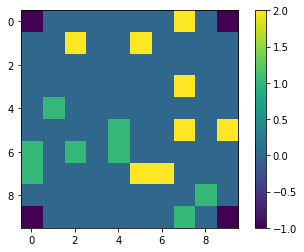

[[-1  0  0  0  0  0  0  2  0 -1]
 [ 0  0  2  0  0  2  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  2  0  0]
 [ 0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  2  0  2]
 [ 1  0  1  0  1  0  0  0  0  0]
 [ 1  0  0  0  0  2  2  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0]
 [-1  1  0  0  0  0  0  1  0 -1]]


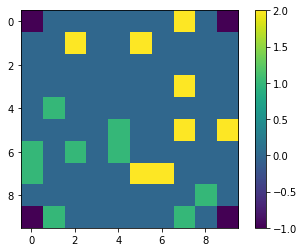

[[-1  0  0  0  0  0  0  2  0 -1]
 [ 0  0  2  0  2  2  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  2  0  0]
 [ 0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  2  0  2]
 [ 1  0  1  0  1  0  0  0  0  0]
 [ 1  0  0  0  0  2  2  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0]
 [-1  1  0  0  0  0  0  1  0 -1]]


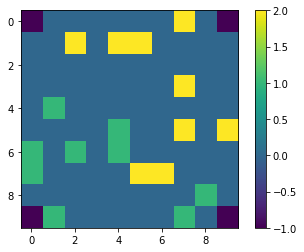

[[-1  0  0  0  0  0  0  2  0 -1]
 [ 0  0  2  0  2  2  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  2  0  0]
 [ 0  1  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  1  0  0  2  0  2]
 [ 1  0  1  0  1  0  0  0  0  0]
 [ 1  0  0  0  0  2  2  0  0  0]
 [ 0  0  0  0  0  0  0  0  1  0]
 [-1  1  0  0  0  0  0  1  0 -1]]


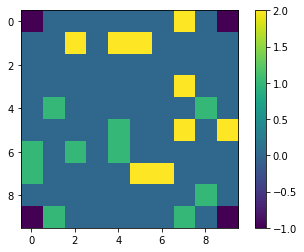

[[-1  0  0  0  0  0  0  2  0 -1]
 [ 0  0  2  0  2  2  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  2  0  0]
 [ 0  1  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  1  0  0  2  0  2]
 [ 1  0  1  0  1  0  0  0  0  0]
 [ 1  0  0  0  0  2  2  0  0  0]
 [ 0  0  0  0  0  0  0  2  1  0]
 [-1  1  0  0  0  0  0  1  0 -1]]


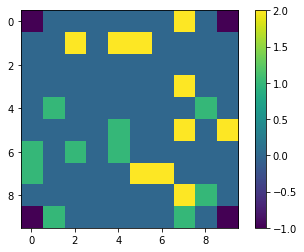

[[-1  0  0  0  0  0  0  2  0 -1]
 [ 0  0  2  0  2  2  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  2  0  0]
 [ 0  1  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  1  0  0  2  0  2]
 [ 1  0  1  0  1  0  0  0  0  0]
 [ 1  0  0  0  1  2  2  0  0  0]
 [ 0  0  0  0  0  0  0  2  1  0]
 [-1  1  0  0  0  0  0  1  0 -1]]


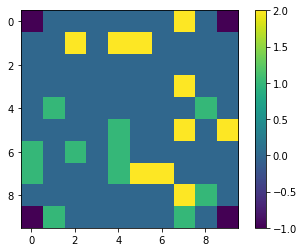

[[-1  0  0  0  0  0  0  2  0 -1]
 [ 0  0  2  0  2  2  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  2  0  2]
 [ 0  1  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  1  0  0  2  0  2]
 [ 1  0  1  0  1  0  0  0  0  0]
 [ 1  0  0  0  1  2  2  0  0  0]
 [ 0  0  0  0  0  0  0  2  1  0]
 [-1  1  0  0  0  0  0  1  0 -1]]


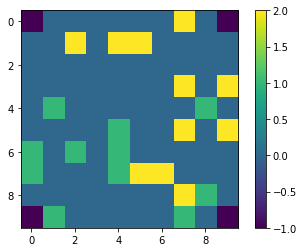

[[-1  0  0  0  0  0  0  2  0 -1]
 [ 0  0  2  0  2  2  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  2  0  2]
 [ 0  1  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  1  0  0  2  0  2]
 [ 1  0  1  0  1  0  0  0  0  0]
 [ 1  0  0  0  1  2  2  0  0  0]
 [ 0  0  0  0  0  1  0  2  1  0]
 [-1  1  0  0  0  0  0  1  0 -1]]


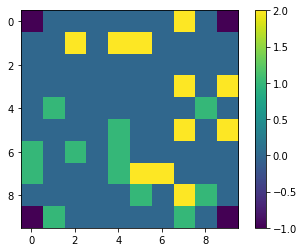

[[-1  0  0  0  0  0  0  2  0 -1]
 [ 0  0  2  2  2  2  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  2  0  2]
 [ 0  1  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  1  0  0  2  0  2]
 [ 1  0  1  0  1  0  0  0  0  0]
 [ 1  0  0  0  1  2  2  0  0  0]
 [ 0  0  0  0  0  1  0  2  1  0]
 [-1  1  0  0  0  0  0  1  0 -1]]


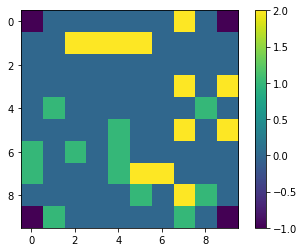

[[-1  0  0  0  0  0  0  2  0 -1]
 [ 0  0  2  2  2  2  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  2  0  2]
 [ 0  1  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  1  0  0  2  0  2]
 [ 1  0  1  0  1  0  0  0  0  0]
 [ 1  0  0  0  1  2  2  0  0  0]
 [ 0  0  0  0  0  1  0  2  1  0]
 [-1  1  0  0  0  0  0  1  0 -1]]


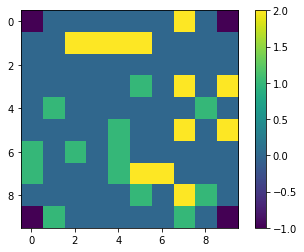

[[-1  0  0  0  0  0  0  2  0 -1]
 [ 0  0  2  2  2  2  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  2  0  2]
 [ 0  1  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  1  0  2  2  0  2]
 [ 1  0  1  0  1  0  0  0  0  0]
 [ 1  0  0  0  1  2  2  0  0  0]
 [ 0  0  0  0  0  1  0  2  1  0]
 [-1  1  0  0  0  0  0  1  0 -1]]


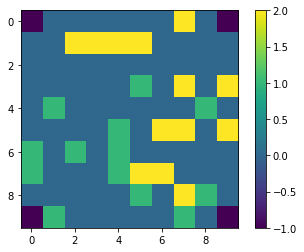

[[-1  0  0  0  0  0  0  2  0 -1]
 [ 0  0  2  2  2  2  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  2  0  2]
 [ 0  1  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  1  0  2  2  0  2]
 [ 1  0  1  0  1  0  0  0  0  0]
 [ 1  0  0  0  1  2  2  0  0  0]
 [ 0  0  0  0  0  1  0  0  1  0]
 [-1  1  0  0  0  0  0  1  0 -1]]


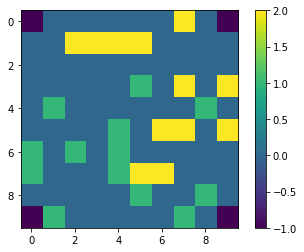

[[-1  0  0  0  0  0  0  2  0 -1]
 [ 2  0  2  2  2  2  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  2  0  2]
 [ 0  1  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  1  0  2  2  0  2]
 [ 1  0  1  0  1  0  0  0  0  0]
 [ 1  0  0  0  1  2  2  0  0  0]
 [ 0  0  0  0  0  1  0  0  1  0]
 [-1  1  0  0  0  0  0  1  0 -1]]


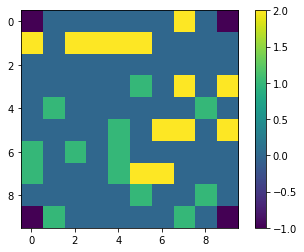

[[-1  0  0  0  0  0  0  2  0 -1]
 [ 2  0  2  2  2  2  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  2  0  2]
 [ 0  1  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  1  0  2  2  0  2]
 [ 1  0  1  0  1  0  0  0  0  0]
 [ 1  0  0  0  1  2  2  0  0  0]
 [ 0  0  0  0  0  1  0  0  1  0]
 [-1  1  0  0  0  0  0  1  0 -1]]


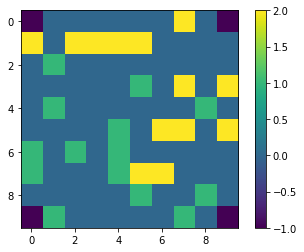

[[-1  2  0  0  0  0  0  2  0 -1]
 [ 2  0  2  2  2  2  0  0  0  0]
 [ 0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  2  0  2]
 [ 0  1  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  1  0  2  2  0  2]
 [ 1  0  1  0  1  0  0  0  0  0]
 [ 1  0  0  0  1  2  2  0  0  0]
 [ 0  0  0  0  0  1  0  0  1  0]
 [-1  1  0  0  0  0  0  1  0 -1]]


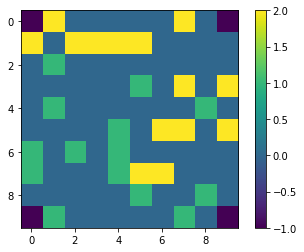

[[-1  2  0  0  0  0  0  2  0 -1]
 [ 2  0  2  2  2  2  0  0  0  0]
 [ 0  1  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  2  0  2]
 [ 0  1  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  1  0  2  2  0  2]
 [ 1  0  1  0  1  0  0  0  0  0]
 [ 1  0  0  0  1  2  2  0  0  0]
 [ 0  0  0  0  0  1  0  0  1  0]
 [-1  1  0  0  0  0  0  1  0 -1]]


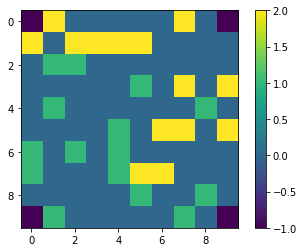

[[-1  2  0  0  0  0  0  2  0 -1]
 [ 2  0  2  2  2  2  0  0  0  0]
 [ 2  1  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  2  0  2]
 [ 0  1  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  1  0  2  2  0  2]
 [ 1  0  1  0  1  0  0  0  0  0]
 [ 1  0  0  0  1  2  2  0  0  0]
 [ 0  0  0  0  0  1  0  0  1  0]
 [-1  1  0  0  0  0  0  1  0 -1]]


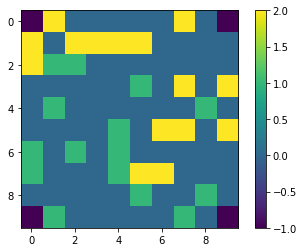

[[-1  2  0  0  0  0  0  2  0 -1]
 [ 2  0  2  2  2  2  0  0  0  0]
 [ 2  1  1  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  2  0  2]
 [ 0  1  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  1  0  2  2  0  2]
 [ 1  0  1  0  1  0  0  0  0  0]
 [ 1  0  0  0  1  2  2  0  0  0]
 [ 0  0  0  0  0  1  0  0  1  0]
 [-1  1  0  0  0  0  0  1  0 -1]]


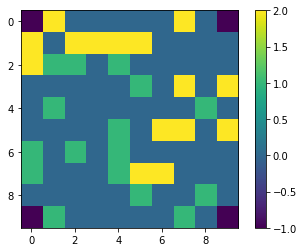

[[-1  2  0  0  0  0  0  2  0 -1]
 [ 2  0  2  2  2  2  0  2  0  0]
 [ 2  1  1  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  2  0  2]
 [ 0  1  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  1  0  2  2  0  2]
 [ 1  0  1  0  1  0  0  0  0  0]
 [ 1  0  0  0  1  2  2  0  0  0]
 [ 0  0  0  0  0  1  0  0  1  0]
 [-1  1  0  0  0  0  0  1  0 -1]]


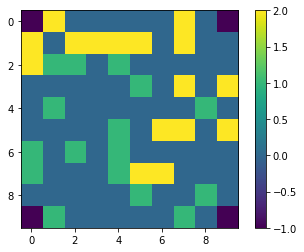

[[-1  2  0  0  0  0  0  2  0 -1]
 [ 2  0  2  2  2  2  0  2  0  1]
 [ 2  1  1  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  2  0  2]
 [ 0  1  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  1  0  2  2  0  2]
 [ 1  0  1  0  1  0  0  0  0  0]
 [ 1  0  0  0  1  2  2  0  0  0]
 [ 0  0  0  0  0  1  0  0  1  0]
 [-1  1  0  0  0  0  0  1  0 -1]]


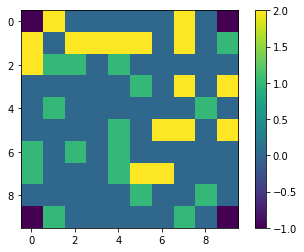

[[-1  2  0  0  0  0  0  2  0 -1]
 [ 2  0  2  2  2  2  0  2  0  1]
 [ 2  1  1  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  2  0  2]
 [ 0  1  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  1  2  2  2  0  2]
 [ 1  0  1  0  1  0  0  0  0  0]
 [ 1  0  0  0  1  2  2  0  0  0]
 [ 0  0  0  0  0  1  0  0  1  0]
 [-1  1  0  0  0  0  0  1  0 -1]]


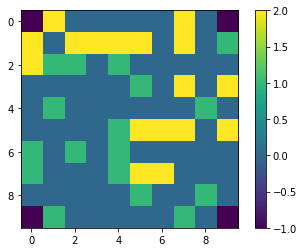

[[-1  2  0  0  0  0  0  2  0 -1]
 [ 2  0  2  2  2  2  0  2  0  1]
 [ 2  1  1  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  2  0  2]
 [ 0  1  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  1  2  2  2  0  2]
 [ 1  0  1  0  1  0  0  0  0  0]
 [ 1  0  0  0  1  2  2  0  0  0]
 [ 1  0  0  0  0  1  0  0  1  0]
 [-1  1  0  0  0  0  0  1  0 -1]]


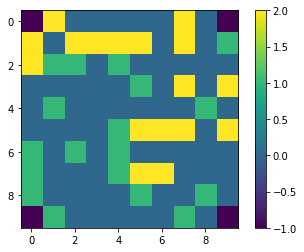

[[-1  2  0  0  0  0  0  2  0 -1]
 [ 2  0  2  2  2  2  0  2  0  1]
 [ 2  1  1  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  2  0  2]
 [ 0  1  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  1  2  2  2  0  2]
 [ 1  0  1  0  1  0  0  0  0  0]
 [ 1  0  0  0  1  2  2  0  0  0]
 [ 1  0  0  0  2  1  0  0  1  0]
 [-1  1  0  0  0  0  0  1  0 -1]]


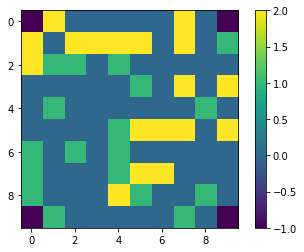

[[-1  2  0  0  0  0  0  2  0 -1]
 [ 2  0  2  2  2  2  0  2  0  1]
 [ 2  1  1  1  1  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  2  0  2]
 [ 0  1  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  1  2  2  2  0  2]
 [ 1  0  1  0  1  0  0  0  0  0]
 [ 1  0  0  0  1  2  2  0  0  0]
 [ 1  0  0  0  2  1  0  0  1  0]
 [-1  1  0  0  0  0  0  1  0 -1]]


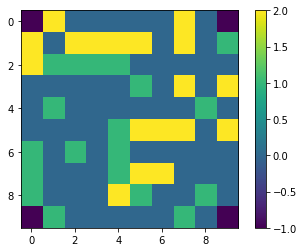

[[-1  2  0  0  0  0  0  2  0 -1]
 [ 2  0  2  2  2  2  0  2  0  1]
 [ 2  1  1  1  1  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  2  0  2]
 [ 0  1  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  1  2  2  2  0  2]
 [ 1  0  1  0  1  0  0  0  0  0]
 [ 1  0  0  0  1  2  2  0  2  0]
 [ 1  0  0  0  2  1  0  0  1  0]
 [-1  1  0  0  0  0  0  1  0 -1]]


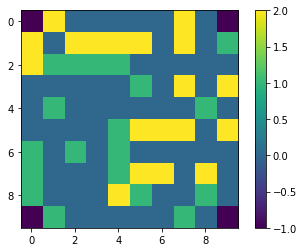

[[-1  2  0  0  0  0  0  2  0 -1]
 [ 2  0  2  2  2  2  0  2  0  1]
 [ 2  1  1  1  1  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  2  0  2]
 [ 0  1  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  1  2  2  2  0  2]
 [ 1  0  1  0  1  0  0  0  0  0]
 [ 1  0  0  0  1  2  2  0  2  0]
 [ 1  1  0  0  2  1  0  0  1  0]
 [-1  1  0  0  0  0  0  1  0 -1]]


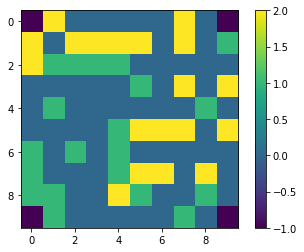

[[-1  2  0  0  0  0  0  2  0 -1]
 [ 2  0  2  2  2  2  0  2  0  1]
 [ 2  1  1  1  1  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  2  0  2]
 [ 0  1  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  1  2  2  2  0  2]
 [ 1  0  1  0  1  0  0  0  0  0]
 [ 1  0  0  0  1  2  2  0  2  0]
 [ 1  1  0  0  2  1  0  0  1  0]
 [-1  1  0  2  0  0  0  1  0 -1]]


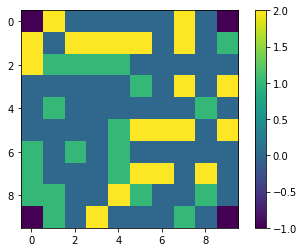

[[-1  2  0  0  0  0  1  2  0 -1]
 [ 2  0  2  2  2  2  0  2  0  1]
 [ 2  1  1  1  1  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  2  0  2]
 [ 0  1  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  1  2  2  2  0  2]
 [ 1  0  1  0  1  0  0  0  0  0]
 [ 1  0  0  0  1  2  2  0  2  0]
 [ 1  1  0  0  2  1  0  0  1  0]
 [-1  1  0  2  0  0  0  1  0 -1]]


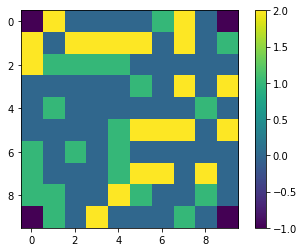

[[-1  2  0  0  0  0  1  2  0 -1]
 [ 2  0  2  2  2  2  0  2  0  1]
 [ 2  1  1  1  1  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  2  0  2]
 [ 0  1  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  1  2  2  2  0  2]
 [ 1  0  1  0  1  0  0  0  0  0]
 [ 1  0  0  0  1  2  2  0  2  2]
 [ 1  1  0  0  2  1  0  0  1  0]
 [-1  1  0  2  0  0  0  1  0 -1]]


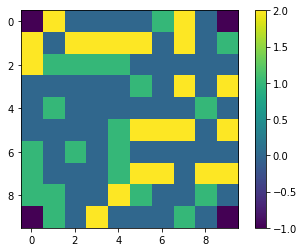

[[-1  2  0  0  0  0  1  2  0 -1]
 [ 2  0  2  2  2  2  0  2  0  1]
 [ 2  1  1  1  1  0  0  0  0  0]
 [ 0  0  0  1  0  1  0  2  0  2]
 [ 0  1  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  1  2  2  2  0  2]
 [ 1  0  1  0  1  0  0  0  0  0]
 [ 1  0  0  0  1  2  2  0  2  2]
 [ 1  1  0  0  2  1  0  0  1  0]
 [-1  1  0  2  0  0  0  1  0 -1]]


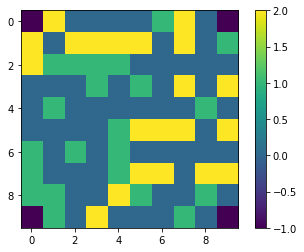

[[-1  2  2  0  0  0  1  2  0 -1]
 [ 2  0  2  2  2  2  0  2  0  1]
 [ 2  1  1  1  1  0  0  0  0  0]
 [ 0  0  0  1  0  1  0  2  0  2]
 [ 0  1  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  1  2  2  2  0  2]
 [ 1  0  1  0  1  0  0  0  0  0]
 [ 1  0  0  0  1  2  2  0  2  2]
 [ 1  1  0  0  2  1  0  0  1  0]
 [-1  1  0  2  0  0  0  1  0 -1]]


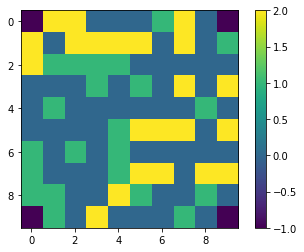

[[-1  2  2  0  0  0  1  2  0 -1]
 [ 2  0  2  2  2  2  0  2  0  1]
 [ 2  1  1  1  1  0  0  0  0  0]
 [ 0  0  0  1  0  1  0  2  0  2]
 [ 0  1  0  0  0  0  0  1  1  0]
 [ 0  0  0  0  1  2  2  2  0  2]
 [ 1  0  1  0  1  0  0  0  0  0]
 [ 1  0  0  0  1  2  2  0  2  2]
 [ 1  1  0  0  2  1  0  0  1  0]
 [-1  1  0  2  0  0  0  1  0 -1]]


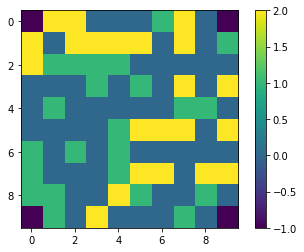

[[-1  2  2  0  0  0  1  2  0 -1]
 [ 2  0  2  2  2  2  0  2  0  1]
 [ 2  1  1  1  1  0  0  0  0  0]
 [ 0  0  0  1  0  1  0  2  0  2]
 [ 0  1  0  0  0  0  0  1  1  0]
 [ 0  0  0  0  1  2  2  2  0  2]
 [ 1  0  1  0  1  0  0  0  0  0]
 [ 1  0  0  0  1  2  2  0  2  2]
 [ 1  1  2  0  2  1  0  0  1  0]
 [-1  1  0  2  0  0  0  1  0 -1]]


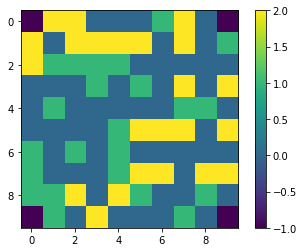

[[-1  2  2  0  0  0  1  2  0 -1]
 [ 2  0  2  2  2  2  0  2  0  1]
 [ 2  1  1  1  1  0  0  0  0  0]
 [ 0  0  0  1  0  1  0  2  0  2]
 [ 0  1  1  0  0  0  0  1  1  0]
 [ 0  0  0  0  1  2  2  2  0  2]
 [ 1  0  1  0  1  0  0  0  0  0]
 [ 1  0  0  0  1  2  2  0  2  2]
 [ 1  1  2  0  2  1  0  0  1  0]
 [-1  1  0  2  0  0  0  1  0 -1]]


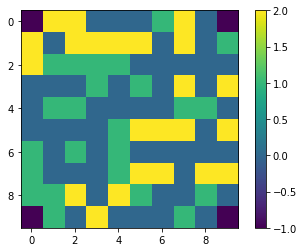

[[-1  2  2  0  0  0  1  2  0 -1]
 [ 2  0  2  2  2  2  0  2  0  1]
 [ 2  1  1  1  1  0  0  0  0  0]
 [ 0  0  0  1  0  1  0  2  0  2]
 [ 0  1  1  0  0  0  0  1  1  0]
 [ 0  0  0  0  1  2  2  2  0  2]
 [ 1  0  1  0  1  0  0  0  0  0]
 [ 1  0  0  0  1  2  2  0  2  2]
 [ 1  1  2  0  2  1  0  0  1  0]
 [-1  1  0  2  0  0  2  1  0 -1]]


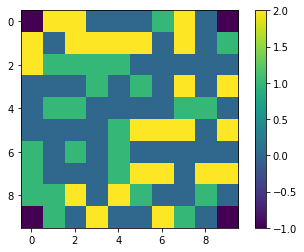

[[-1  2  2  0  0  0  1  2  0 -1]
 [ 2  0  2  2  2  2  0  2  0  1]
 [ 2  1  1  1  1  0  0  0  0  0]
 [ 0  0  0  1  0  1  0  2  0  2]
 [ 0  1  1  0  0  0  0  1  1  0]
 [ 0  0  0  0  1  2  2  2  0  2]
 [ 1  0  1  0  1  0  0  0  0  1]
 [ 1  0  0  0  1  2  2  0  2  2]
 [ 1  1  2  0  2  1  0  0  1  0]
 [-1  1  0  2  0  0  2  1  0 -1]]


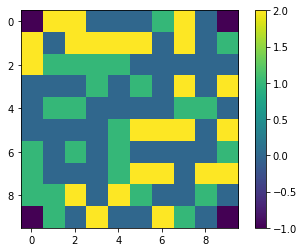

[[-1  2  2  0  0  0  1  2  0 -1]
 [ 2  0  2  2  2  2  0  2  0  1]
 [ 2  1  1  1  1  0  0  0  0  0]
 [ 0  0  0  1  0  1  0  2  0  2]
 [ 0  1  1  0  0  0  0  1  1  0]
 [ 0  0  0  0  1  2  2  2  0  2]
 [ 1  0  1  0  1  0  0  2  0  1]
 [ 1  0  0  0  1  2  2  0  2  2]
 [ 1  1  2  0  2  1  0  0  1  0]
 [-1  1  0  2  0  0  2  1  0 -1]]


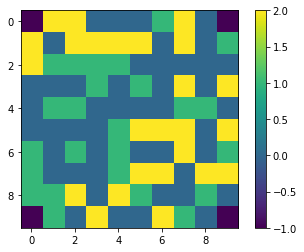

[[-1  2  2  0  0  0  1  2  0 -1]
 [ 2  1  2  2  2  2  0  2  0  1]
 [ 2  1  1  1  1  0  0  0  0  0]
 [ 0  0  0  1  0  1  0  2  0  2]
 [ 0  1  1  0  0  0  0  1  1  0]
 [ 0  0  0  0  1  2  2  2  0  2]
 [ 1  0  1  0  1  0  0  2  0  1]
 [ 1  0  0  0  1  2  2  0  2  2]
 [ 1  1  2  0  2  1  0  0  1  0]
 [-1  1  0  2  0  0  2  1  0 -1]]


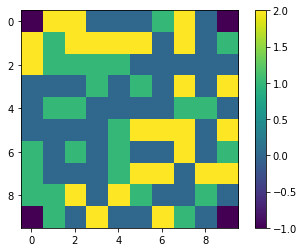

[[-1  2  2  0  2  0  1  2  0 -1]
 [ 2  1  2  2  2  2  0  2  0  1]
 [ 2  1  1  1  1  0  0  0  0  0]
 [ 0  0  0  1  0  1  0  2  0  2]
 [ 0  1  1  0  0  0  0  1  1  0]
 [ 0  0  0  0  1  2  2  2  0  2]
 [ 1  0  1  0  1  0  0  2  0  1]
 [ 1  0  0  0  1  2  2  0  2  2]
 [ 1  1  2  0  2  1  0  0  1  0]
 [-1  1  0  2  0  0  2  1  0 -1]]


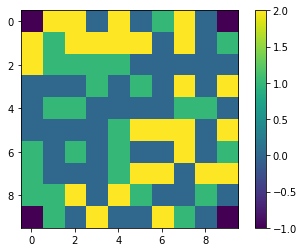

[[-1  2  2  0  2  0  1  2  0 -1]
 [ 2  1  2  2  2  2  0  2  0  1]
 [ 2  1  1  1  1  0  0  0  0  1]
 [ 0  0  0  1  0  1  0  2  0  2]
 [ 0  1  1  0  0  0  0  1  1  0]
 [ 0  0  0  0  1  2  2  2  0  2]
 [ 1  0  1  0  1  0  0  2  0  1]
 [ 1  0  0  0  1  2  2  0  2  2]
 [ 1  1  2  0  2  1  0  0  1  0]
 [-1  1  0  2  0  0  2  1  0 -1]]


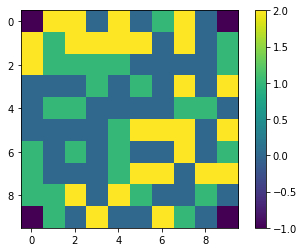

[[-1  2  2  0  2  0  1  2  0 -1]
 [ 2  1  2  2  2  2  0  2  0  1]
 [ 2  1  1  1  1  0  0  0  0  1]
 [ 0  0  0  1  0  1  0  2  0  2]
 [ 0  1  0  0  0  0  0  1  1  0]
 [ 0  0  0  0  1  2  2  2  0  2]
 [ 1  0  1  0  1  0  0  2  0  1]
 [ 1  0  0  0  1  2  2  0  2  2]
 [ 1  1  2  0  2  1  0  0  1  0]
 [-1  1  0  2  0  0  2  1  0 -1]]


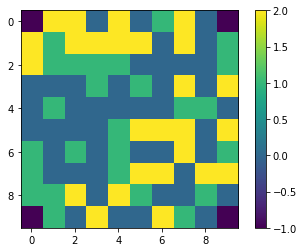

[[-1  2  2  0  2  0  1  2  0 -1]
 [ 2  1  2  2  2  2  0  2  0  1]
 [ 2  1  1  1  1  1  0  0  0  1]
 [ 0  0  0  1  0  1  0  2  0  2]
 [ 0  1  0  0  0  0  0  1  1  0]
 [ 0  0  0  0  1  2  2  2  0  2]
 [ 1  0  1  0  1  0  0  2  0  1]
 [ 1  0  0  0  1  2  2  0  2  2]
 [ 1  1  2  0  2  1  0  0  1  0]
 [-1  1  0  2  0  0  2  1  0 -1]]


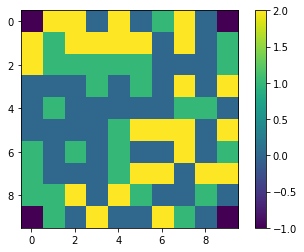

[[-1  2  2  0  2  0  1  2  0 -1]
 [ 2  1  2  2  2  2  0  2  0  1]
 [ 2  1  1  1  1  1  0  0  0  1]
 [ 0  0  0  1  0  1  0  2  0  2]
 [ 0  1  0  0  0  0  0  1  1  0]
 [ 0  0  0  0  1  2  2  2  0  2]
 [ 1  0  1  0  1  0  0  2  0  1]
 [ 1  0  2  0  1  2  2  0  2  2]
 [ 1  1  2  0  2  1  0  0  1  0]
 [-1  1  0  2  0  0  2  1  0 -1]]


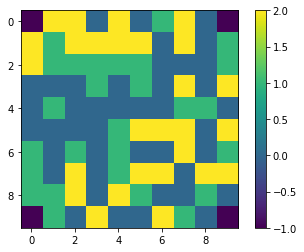

[[-1  2  2  0  2  0  1  2  0 -1]
 [ 2  1  2  2  2  2  0  2  0  1]
 [ 2  1  1  1  1  1  0  0  0  1]
 [ 0  0  1  1  0  1  0  2  0  2]
 [ 0  1  0  0  0  0  0  1  1  0]
 [ 0  0  0  0  1  2  2  2  0  2]
 [ 1  0  1  0  1  0  0  2  0  1]
 [ 1  0  2  0  1  2  2  0  2  2]
 [ 1  1  2  0  2  1  0  0  1  0]
 [-1  1  0  2  0  0  2  1  0 -1]]


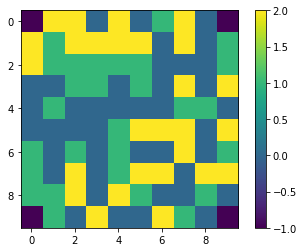

[[-1  2  2  0  2  0  1  2  0 -1]
 [ 2  1  2  2  2  2  0  2  0  1]
 [ 2  1  1  1  1  1  0  0  0  1]
 [ 2  0  1  1  0  1  0  2  0  2]
 [ 0  1  0  0  0  0  0  1  1  0]
 [ 0  0  0  0  1  2  2  2  0  2]
 [ 1  0  1  0  1  0  0  2  0  1]
 [ 1  0  2  0  1  2  2  0  2  2]
 [ 1  1  2  0  2  1  0  0  1  0]
 [-1  1  0  2  0  0  2  1  0 -1]]


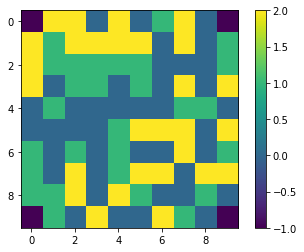

no_feasible_move =  0  player =  1  cards in deck =  25  last played card at coords: ( 4 4 )
[[-1  2  2  0  2  0  1  2  0 -1]
 [ 2  1  2  2  2  2  0  2  0  1]
 [ 2  1  1  1  1  1  0  0  0  1]
 [ 2  0  1  1  0  1  0  2  0  2]
 [ 0  1  0  0  1  0  0  1  1  0]
 [ 0  0  0  0  1  2  2  2  0  2]
 [ 1  0  1  0  1  0  0  2  0  1]
 [ 1  0  2  0  1  2  2  0  2  2]
 [ 1  1  2  0  2  1  0  0  1  0]
 [-1  1  0  2  0  0  2  1  0 -1]]


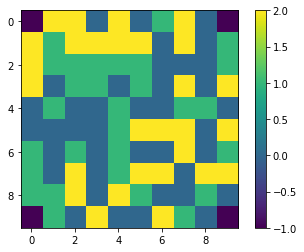

In [2]:
env = SequenceEnv()

print(env.discs_on_board)

env.play_full_game()